In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
import weightedstats as ws


## Datapreparation and Loading

In [2]:
df = pd.read_csv(
    "Life Expectancy Data.csv"
)  # https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

# This is the dataset acutally from the worldbank to clean up the other data and impute by hand.
df_pop = pd.read_csv(
    "Population_DATA_WHO.csv"
)  # https://databank.worldbank.org/source/world-development-indicators/preview/on#

# GDP Data
df_gdp = pd.read_csv(
    "GDP_DATA_WHO.csv"
)  # https://databank.worldbank.org/source/world-development-indicators/preview/on#

# dataset to clean up the Hepatitis values
df_hep = pd.read_csv(
    "HEP_B_DATA_WHO.csv"
)  # https://databank.worldbank.org/source/world-development-indicators/preview/on#

# dataset to clean up the HIV values
df_HIV = pd.read_csv("WHO_AIDS.csv")

# dataset to contextualisze human improvement
df_income_share = pd.read_csv("incomeshare_WHO.csv")

# drop na for WHO data (nan here has a different meaning)
df_pop.dropna(inplace=True)
df_hep.dropna(inplace=True)
df_HIV.dropna(inplace=True)
df_gdp.dropna(inplace=True)
df_income_share.dropna(inplace=True)

# sort the dataframe to make sense.
df = df.sort_values(["Country", "Year"]).reset_index().drop(columns="index")

# position for later
col_loc = df.columns.get_loc(" HIV/AIDS")


## Cleaning the dataset

In [3]:
# giving the dataset with the correct population meassures the same column names as they are used
# in the first data set.

col_first = []
year_list = [*range(2000, 2016, 1)]

col_first = df_pop.columns[:4].to_list()
col_first.extend(year_list)
df_pop.columns = col_first
df_pop.drop(columns=["Series Name", "Series Code", "Country Code"], inplace=True)
df_pop = df_pop.rename(columns={"Country Name": "Country"})

# giving the dataset with the correct GDP meassures the same column names as they are used
# in the first data set.

col_first = []
col_first = df_gdp.columns[:4].to_list()
col_first.extend(year_list)

df_gdp.columns = col_first
df_gdp.drop(columns=["Series Name", "Series Code", "Country Code"], inplace=True)
df_gdp = df_gdp.rename(columns={"Country Name": "Country"})

# giving the dataset with the correct Hepatitis B meassures the same column names as they are used
# in the first data set.

col_first = []
col_first = df_hep.columns[:4].to_list()
col_first.extend(year_list)

df_hep.columns = col_first
df_hep.drop(columns=["Series Name", "Series Code", "Country Code"], inplace=True)
df_hep = df_hep.rename(columns={"Country Name": "Country"})


# giving the dataset with the correct HIV meassures the same column names as they are used
# in the first data set.

col_first = []
col_first = df_HIV.columns[:4].to_list()
col_first.extend(year_list)

df_HIV.columns = col_first
df_HIV.drop(columns=["Series Name", "Series Code", "Country Code"], inplace=True)
df_HIV = df_HIV.rename(columns={"Country Name": "Country"})

# giving the dataset with the income share meassures the same column names as they are used
# in the first data set.

year_list = [*range(1972, 2022, 1)]
col_first = []
col_first = df_income_share.columns[:4].to_list()
col_first.extend(year_list)
df_income_share.columns = col_first
df_income_share.drop(columns=["Series Code", "Country Code"], inplace=True)
df_income_share = df_income_share.rename(columns={"Country Name": "Country"})

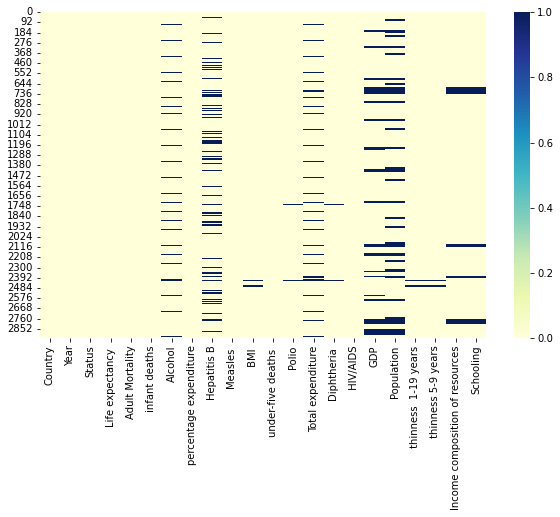

In [4]:
# checking how many nan, there are.
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cmap="YlGnBu")
plt.show()


In [5]:
# Since there are many nan, we need at least to add the missing and wrong(!) population sizes.
# Create a dictionary to map values to new values, so that the merger between both dfs will be easier.
replace_dict = {
    "Vietnam": "Viet Nam",
    "Yemen, Rep.": "Yemen",
    "Venezuela, RB": "Venezuela (Bolivarian Republic of)",
    "United States": "United States of America",
    "Tanzania": "United Republic of Tanzania",
    "United Kingdom": "United Kingdom of Great Britain and Northern Ireland",
    "Turkiye": "Turkey",
    "North Macedonia": "The former Yugoslav republic of Macedonia",
    "Eswatini": "Swaziland",
    "Slovak Republic": "Slovakia",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "St. Lucia": "Saint Lucia",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "Moldova": "Republic of Moldova",
    "Korea, Rep.": "Republic of Korea",
    "Micronesia, Fed. Sts.": "Micronesia (Federated States of)",
    "Lao PDR": "Lao People's Democratic Republic",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Iran, Islamic Rep.": "Iran (Islamic Republic of)",
    "Gambia, The": "Gambia",
    "Egypt, Arab Rep.": "Egypt",
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Korea, Dem. People's Rep.": "Democratic People's Republic of Korea",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Congo, Rep.": "Congo",
    "Bolivia": "Bolivia (Plurinational State of)",
    "Bahamas, The": "Bahamas",
}

# Replace values in the DataFrame using the dictionary
df_pop.replace(replace_dict, inplace=True)
df_gdp.replace(replace_dict, inplace=True)
df_hep.replace(replace_dict, inplace=True)
df_HIV.replace(replace_dict, inplace=True)

# Melt the dataframe to convert the years columns to a single 'Year' column
melted_pop = pd.melt(
    df_pop, id_vars=["Country"], var_name="Year", value_name="Population"
)
melted_pop.sort_values(["Country", "Year"], inplace=True)
melted_pop.reset_index(inplace=True)
melted_pop.drop(columns="index", inplace=True)

# Melt the dataframe to convert the years columns to a single 'Year' column
melted_GDP = pd.melt(df_gdp, id_vars=["Country"], var_name="Year", value_name="GDP")
melted_GDP.sort_values(["Country", "Year"], inplace=True)
melted_GDP.reset_index(inplace=True)
melted_GDP.drop(columns="index", inplace=True)

# Melt the dataframe to convert the years columns to a single 'Year' column
melted_Hep = pd.melt(
    df_hep, id_vars=["Country"], var_name="Year", value_name="Hepatitis B"
)
melted_Hep.sort_values(["Country", "Year"], inplace=True)
melted_Hep.reset_index(inplace=True)
melted_Hep.drop(columns="index", inplace=True)


# Melt the dataframe to convert the years columns to a single 'Year' column
melted_HIV = pd.melt(
    df_HIV, id_vars=["Country"], var_name="Year", value_name=" HIV/AIDS"
)
melted_HIV.sort_values(["Country", "Year"], inplace=True)
melted_HIV.reset_index(inplace=True)
melted_HIV.drop(columns="index", inplace=True)

# Melt the dataframe to convert the years columns to a single 'Year' column and drop the unsed
df_income_share.drop(columns=[*range(1972, 1991, 1), 2019, 2020, 2021], inplace=True)
df_melted_income = pd.melt(
    df_income_share,
    id_vars=["Country", "Series Name"],
    var_name="Year",
    value_name="Income Share",
)

# creating sets to see, if I got all the name the same
countries_df1 = set(df["Country"])
countries_df2 = set(df_pop["Country"])

# Find the distinct 'Country' values that are not the same in each dataframe
distinct_df1 = countries_df1 - countries_df2
print(distinct_df1)


{'Cook Islands', 'Niue'}


In [6]:
# Merge the two dataframes based on 'Year' and 'Country'
df = pd.merge(melted_pop, df, on=["Year", "Country"], how="inner")
df.drop(columns="Population_y", inplace=True)
df.rename(columns={"Population_x": "Population"}, inplace=True)
df["Population"] = df["Population"].astype(int)

# Merge the two dataframes based on 'Year' and 'Country'
df = pd.merge(melted_GDP, df, on=["Year", "Country"], how="inner")
df.drop(columns="GDP_y", inplace=True)
df.rename(columns={"GDP_x": "GDP"}, inplace=True)


# Merge the two dataframes based on 'Year' and 'Country'
df = pd.merge(melted_Hep, df, on=["Year", "Country"], how="inner")
df.drop(columns="Hepatitis B_y", inplace=True)
df.rename(columns={"Hepatitis B_x": "Hepatitis B"}, inplace=True)


# Merge the two dataframes based on 'Year' and 'Country'
df = pd.merge(melted_HIV, df, on=["Year", "Country"], how="inner")
df.drop(columns=" HIV/AIDS_y", inplace=True)
df.rename(columns={" HIV/AIDS_x": " HIV/AIDS"}, inplace=True)

df.replace("..", np.nan, inplace=True)

In [7]:
df["GDP"] = pd.to_numeric(df["GDP"], errors="coerce")
df[" HIV/AIDS"] = pd.to_numeric(df[" HIV/AIDS"], errors="coerce")
df["Hepatitis B"] = pd.to_numeric(df["Hepatitis B"], errors="coerce")

# Transform np.nan to -1, so that I can get rid of all the decimals
df["GDP"] = df["GDP"].replace([np.nan, np.inf, -np.inf], -1)

# not the most elegant soluation, but somehow the only one, to get rid of those decimals.
for i, x in enumerate(df["GDP"]):
    df.at[i, "GDP"] = int(x)


# Transform np.nan to -1, so that I can get rid of all the decimals
df["GDP"] = df["GDP"].replace(-1, np.nan)


In [8]:
# delete countries that are dont have all the years in the list
freq = df["Country"].value_counts()

# select the rows to delete
cond = df["Country"].map(freq) < 16
delete_list = df["Country"][cond].values
delete_list = ", ".join(delete_list)

print(
    f"The following staates {delete_list} have been deleted, because they are rarer than the time frame"
)

# drop it!
df = df.drop(df[cond].index)

The following staates Dominica, Marshall Islands, Monaco, Nauru, Palau, Saint Kitts and Nevis, San Marino, Tuvalu have been deleted, because they are rarer than the time frame


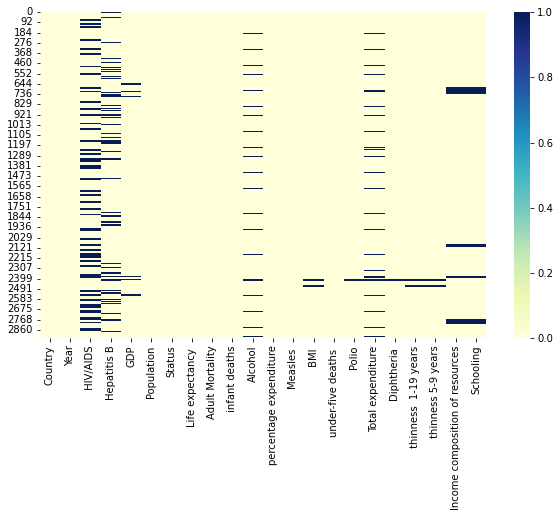

In [9]:
# check if the data combination worked.
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cmap="YlGnBu")
plt.show()


In [10]:
# after all, the Hepatitis B column is still full of missing values, that is why I am dropping it.
df.drop(columns="Hepatitis B", inplace=True)

# get all rows that contain NaN values
rows_with_nan = df[df.isna().any(axis=1)]

len(rows_with_nan["Country"].unique())
# Still 182 country that somewhere miss values, therefore I am conditionally imputing the values.

182

c:\Users\Max_G\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


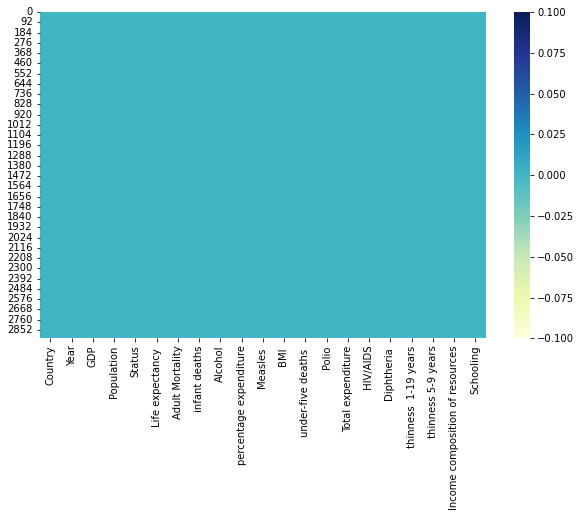

finally the dataset is in a usable state


In [11]:
# Splitting the dataframe in two parts for easier imputing based on the status column

df_developed = df[df["Status"] == "Developed"]
df_developing = df[df["Status"] == "Developing"]

# Creating the imputer for df_developed
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df_developed)

# transform the data using the fitted imputer
df_developed_imputed = pd.DataFrame(
    imputer.transform(df_developed), columns=df_developed.columns
)

# Creating the imputer for df_developing
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df_developing)

# transform the data using the fitted imputer
df_developing_imputed = pd.DataFrame(
    imputer.transform(df_developing), columns=df_developing.columns
)

df_imputed = pd.concat([df_developed_imputed, df_developing_imputed])
df_imputed.sort_values(["Country", "Year"], inplace=True)
df_imputed.reset_index(inplace=True)
df_imputed.drop(columns="index", inplace=True)

# adding the HIV col to the right position

col_HIV = df_imputed.pop(" HIV/AIDS")
df_imputed.insert(col_loc, " HIV/AIDS", col_HIV)


# Create two grouped dataframes, so that we can work with country averages.
grouped_country = df_imputed.groupby("Country").mean().reset_index()
grouped_country_drop_na = grouped_country.dropna().reset_index()

# transform some float values into int
grouped_country["Population"] = grouped_country["Population"].astype(int)


# check if the imputation worked
plt.figure(figsize=(10, 6))
sns.heatmap(df_imputed.isna(), cmap="YlGnBu")
plt.show()

print("finally the dataset is in a usable state")

In [12]:
del df_hep
del df_gdp
del df_HIV
del df_pop
del df_developed
del df_developed_imputed
del df_developing_imputed
del df_developing
del grouped_country_drop_na
del melted_GDP
del melted_Hep
del melted_HIV
del melted_pop
del distinct_df1
del countries_df1
del countries_df2

# Visualisations

## Measures of central tendency
### Unweighted

In [13]:
cols = []
for col in grouped_country.drop(columns=["Country", "Year"]):
    cols.append(col)

# Calculate mean, median, mode and standard deviation for the selected columns
mean = grouped_country[cols].mean()
median = grouped_country[cols].median()
mode = grouped_country[cols].mode().iloc[0]
std = grouped_country[cols].std()

# Create a list of lists to store the data
data = []
for i in range(len(cols)):
    data.append([cols[i], mean[i], median[i], mode[i], std[i]])

# Print the data in a tabular format
headers = ["Column", "Mean", "Median", "Mode", "Standard Deviation"]
print(tabulate(data, headers=headers))


Column                                      Mean          Median        Mode    Standard Deviation
-------------------------------  ---------------  --------------  ----------  --------------------
GDP                              14940.3          8425.25          1051            18152.7
Population                           3.67425e+07     8.29624e+06  82738                1.35622e+08
Life expectancy                     69.2249         72.4875          73.6188           9.18643
Adult Mortality                    164.796         146.562           63.625           96.1852
infant deaths                       30.4074          2.9375           0              115.996
Alcohol                              4.31133         3.39812          0.01             3.62414
percentage expenditure             740.321         183.663            0             1480.93
Measles                           2427.86          175                0             8080.99
BMI                                 37.847         

## Measures of central tendency
### Weighted

In [14]:
output = []
for i, col in enumerate(grouped_country.columns[2:]):
    row = []
    row.append(col)
    if col == "Population":
        row.append(grouped_country[col].mean())
    else:
        weighted_mean = np.average(
            grouped_country[col], weights=grouped_country["Population"]
        )
        row.append(weighted_mean)
    row.append(
        ws.weighted_median(grouped_country[col], weights=grouped_country["Population"])
    )
    row.append(grouped_country.loc[grouped_country["Population"].idxmax()][2:][i])
    weighted_std = np.sqrt(
        np.average(
            (grouped_country[col] - row[1]) ** 2, weights=grouped_country["Population"]
        )
    )
    row.append(weighted_std)
    output.append(row)

print(
    tabulate(
        output,
        headers=[
            "Column",
            "Weighted Mean",
            "Weighted Median",
            "Mode",
            "Weighted Standard Deviation",
        ],
    )
)

Column                             Weighted Mean    Weighted Median             Mode    Weighted Standard Deviation
-------------------------------  ---------------  -----------------  ---------------  -----------------------------
GDP                              11530.6             7474.19          7474.19                       12646.7
Population                           3.67425e+07        1.84039e+08      1.32124e+09                    7.55154e+08
Life expectancy                     69.9325            72.85            74.2625                         7.56464
Adult Mortality                    139.233            146.562           73.75                          75.1284
infant deaths                      349.332            151.188          294.875                        490.201
Alcohol                              3.9321             3.92125          3.92125                        3.17767
percentage expenditure             406.246             73.5838          73.5838                    

##  Correlation Matrix


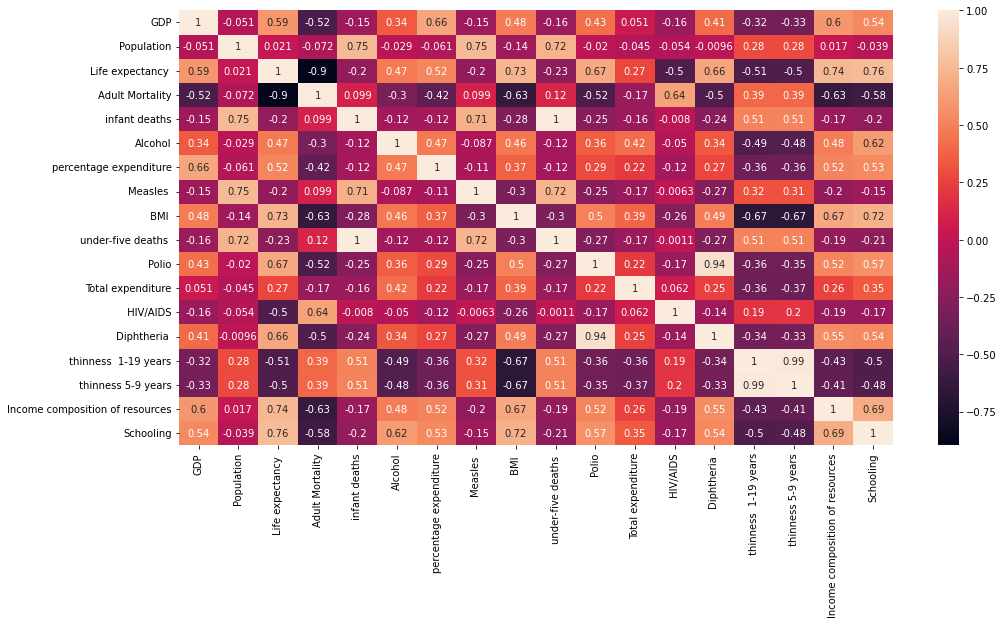

In [15]:
corr_matrix = grouped_country.drop(columns="Year").corr("pearson")

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corr_matrix, ax=ax, annot=True)

plt.show()


### Highest correlations

In [16]:
# getting absolut values of the correlation matrix
abs_corr_matrix = corr_matrix.abs()
abs_corr_matrix = abs_corr_matrix[abs_corr_matrix != 1.0]

top_abs_corr = abs_corr_matrix.unstack().sort_values(ascending=False)[:60:2]

bottom_abs_corr = abs_corr_matrix.unstack().sort_values()[:60:2]

print("Highest correlation in absolute value\n\n", top_abs_corr)


Highest correlation in absolute value

 under-five deaths                infant deaths                      0.996959
 thinness  1-19 years             thinness 5-9 years                0.985179
Diphtheria                       Polio                              0.944162
Life expectancy                  Adult Mortality                    0.896441
                                 Schooling                          0.759432
Measles                          Population                         0.750023
infant deaths                    Population                         0.748969
Life expectancy                  Income composition of resources    0.742548
 BMI                             Life expectancy                    0.727758
Measles                          under-five deaths                  0.719636
under-five deaths                Population                         0.718708
 BMI                             Schooling                          0.715908
infant deaths                    Mea

### Lowest correlations

In [17]:
print("Closest to zero correlation\n\n", bottom_abs_corr)

Closest to zero correlation

  HIV/AIDS                        under-five deaths         0.001102
                                 Measles                   0.006322
infant deaths                     HIV/AIDS                 0.008001
Diphtheria                       Population                0.009590
Income composition of resources  Population                0.017264
Population                       Polio                     0.019764
                                 Life expectancy           0.020982
                                 Alcohol                   0.028504
Schooling                        Population                0.038892
Population                       Total expenditure         0.045253
 HIV/AIDS                        Alcohol                   0.049622
Population                       GDP                       0.051168
Total expenditure                GDP                       0.051354
Population                        HIV/AIDS                 0.054426
                  

### Features that correlate the most

In [18]:
abs_corr_matrix.mean().sort_values(ascending=False)

Life expectancy                    0.497556
 BMI                               0.473580
Schooling                          0.449291
 thinness  1-19 years              0.442395
 thinness 5-9 years                0.439548
Income composition of resources    0.426462
Adult Mortality                    0.410820
Polio                              0.392085
Diphtheria                         0.385708
GDP                                0.349718
Alcohol                            0.331160
under-five deaths                  0.329864
percentage expenditure             0.325006
infant deaths                      0.322220
Measles                            0.282485
Total expenditure                  0.230833
Population                         0.196780
 HIV/AIDS                          0.172015
dtype: float64

# Visualisations 
## Overview over the dataset. 
KDE histograms for each numeric collumn. 
Some contain truncated y-axis, because the mode is way more frequent the the second most frequent value.
These are all zero inflated datasets and we do not learn too much, because this shows the count of states on the y-axis.
Will the visualizations look good, the have a key problem. They are not weighted. We only the the freqeuncy of states in the histograms.

In [19]:
# column explanations

column_short_explanations = {
    "Life expectancy ": "In Years",
    "Adult Mortality": "Per 1000",
    "infant deaths": "Per 1000",
    "Alcohol": "In Litres",
    "percentage expenditure": "Percent of GDP for Health",
    "Measles ": "Per 1000",
    " BMI ": "Average of Population",
    "under-five deaths ": "Per 1000",
    "Polio": "Immun. 1 year old in %",
    "Total expenditure": " '%' of Gov.-Exp. Health",
    "Diphtheria ": "Immun. 1 year old in %",
    " HIV/AIDS": " Positive per 1000",
    "GDP": "In USD",
    "Population": "Population of Country",
    " thinness  1-19 years": "Among children in %",
    " thinness 5-9 years": "Among children in %",
    "Income composition of resources": "Human Development Index 0 to 1",
    "Schooling": "In Years",
}


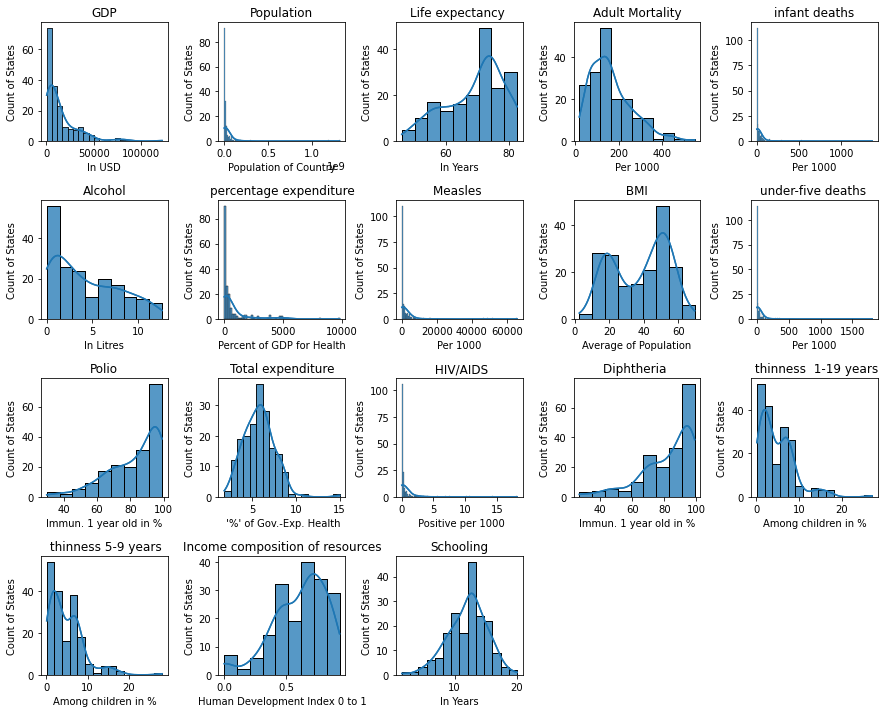

In [20]:
# automatically define the number of rows with respect to the number of collumns

num_cols = 5
num_rows = (len(grouped_country.columns[2:]) // num_cols) + (
    len(grouped_country.columns[2:]) % num_cols > 0
)

# Create a figure and axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Flatten the axes object to simplify indexing
axs = axs.flatten()

# Loop through each column of the dataframe and create a histogram plot
# Truncated the y-axis where the mode has a higher value then the second most frequent value
for i, col in enumerate(grouped_country.columns[2:]):
    sns.histplot(data=grouped_country, x=col, ax=axs[i], kde=True)
    if col in column_short_explanations:
        axs[i].set_xlabel(column_short_explanations[col])
    else:
        axs[i].set_xlabel("")
    axs[i].set_title(col)
    axs[i].set_ylabel("Count of States")

# Loop through each column of the dataframe and create a histogram plot
for i, col in enumerate(grouped_country.columns[2:]):
    sns.histplot(data=grouped_country, x=col, ax=axs[i], kde=True)
    if col in column_short_explanations:
        axs[i].set_xlabel(column_short_explanations[col])

    else:
        axs[i].set_xlabel("")

# adjust the spacing
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# delete the unused axis, please python-god, forgive me for what I have done,
unused_range_list = []
unused_range_list = range(len(grouped_country.columns[2:]), num_rows * num_cols)
for i in unused_range_list:
    fig.delaxes(axs[i])

plt.show()

# 2. Visualisation
### Two meaningfull histograms

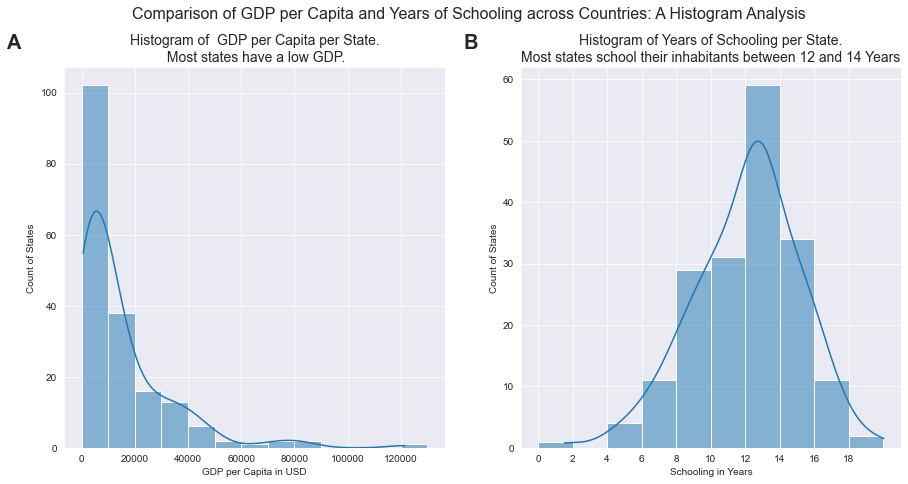

In [21]:
sns.set_style("dark")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(
    data=grouped_country,
    x="GDP",
    ax=ax1,
    kde=True,
    bins=[i for i in range(0, 140000, 10000)],
)
sns.histplot(
    data=grouped_country,
    x="Schooling",
    ax=ax2,
    kde=True,
    bins=[i for i in range(0, 22, 2)],
)

ax1.set_xlabel("GDP per Capita in USD", fontsize=10)
ax1.set_title(
    "Histogram of  GDP per Capita per State.\n Most states have a low GDP.", fontsize=14
)
ax1.set_ylabel("Count of States", fontsize=10)
ax1.set_xticks([i for i in range(0, 140000, 20000)])
ax1.grid(True)

ax2.set_xlabel("Schooling in Years", fontsize=10)
ax2.set_title(
    "Histogram of Years of Schooling per State.\nMost states school their inhabitants between 12 and 14 Years",
    fontsize=14,
)
ax2.set_ylabel("Count of States", fontsize=10)
ax2.set_xticks([i for i in range(0, 20, 2)])
ax2.grid(True)

ax1.text(-0.15, 1.05, "A", transform=ax1.transAxes, size=20, weight="bold")
ax2.text(-0.15, 1.05, "B", transform=ax2.transAxes, size=20, weight="bold")

fig.suptitle(
    "Comparison of GDP per Capita and Years of Schooling across Countries: A Histogram Analysis",
    fontsize=16,
    y=1,
)

plt.show()


## Create Boxplots for all collumns.
The data is grouped for states, hence the boxplots are not easy to interpret

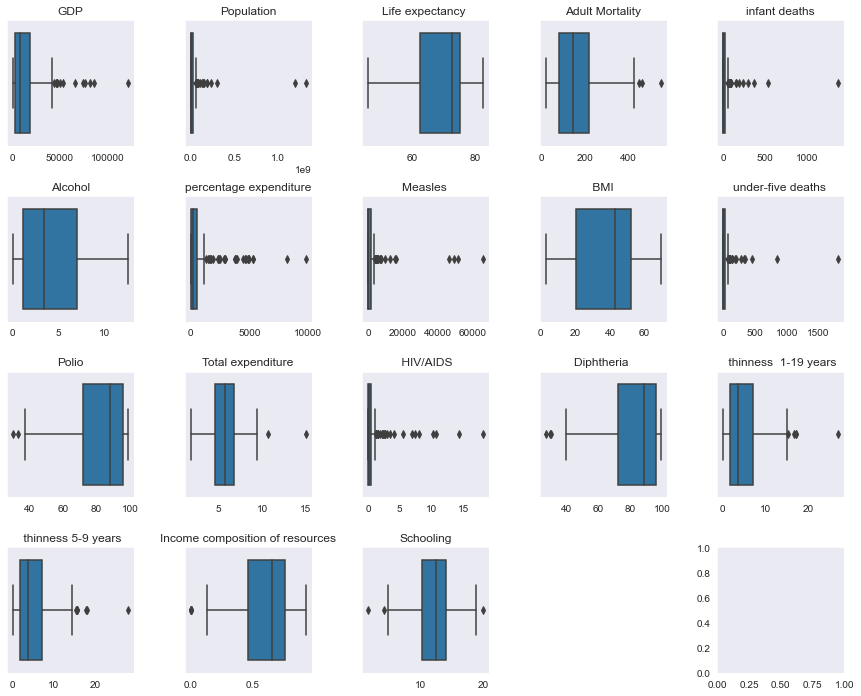

In [22]:
# automatically define the number of rows with respect to the number of collumns
num_cols = 5
num_rows = (len(grouped_country.columns[2:]) // num_cols) + (
    len(grouped_country.columns[2:]) % num_cols > 0
)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Flatten the axes object to simplify indexing
axs = axs.flatten()

# Loop through each column of the dataframe and create a histogram plot
for i, col in enumerate(grouped_country.columns[2:]):
    sns.boxplot(x=grouped_country[col], ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

# adjust the spacing
plt.subplots_adjust(wspace=0.4, hspace=0.4)
# delete the unused axis
fig.delaxes(axs[len(grouped_country.columns[2:])])

plt.show()


### Median and Quantiles for different measurements

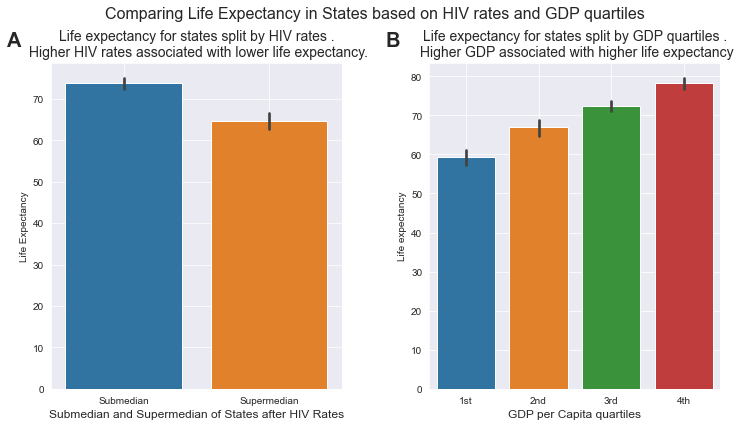

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

grouped_country["rank_HIV"] = grouped_country[" HIV/AIDS"].rank(method="first")
grouped_country["Quantile_HIV"] = pd.qcut(
    grouped_country["rank_HIV"], q=2, labels=False
)


sns.barplot(data=grouped_country, x="Quantile_HIV", y="Life expectancy ", ax=ax1)
ax1.set_xlabel("Submedian and Supermedian of States after HIV Rates", fontsize=12)
ax1.set_title(
    "Life expectancy for states split by HIV rates .\n Higher HIV rates associated with lower life expectancy.",
    fontsize=14,
)
ax1.set_ylabel("Life Expectancy", fontsize=10)

ax1.grid(True)


grouped_country["rank_GDP"] = grouped_country["GDP"].rank(method="first")
grouped_country["Quantile_GDP"] = pd.qcut(
    grouped_country["rank_GDP"], q=4, labels=False
)

sns.barplot(data=grouped_country, x="Quantile_GDP", y="Life expectancy ", ax=ax2)
ax2.set_xlabel("GDP per Capita quartiles", fontsize=12)
ax2.set_title(
    "Life expectancy for states split by GDP quartiles .\n Higher GDP associated with higher life expectancy",
    fontsize=14,
)
ax2.set_ylabel("Life expectancy", fontsize=10)
ax2.grid(True)

ax1.text(-0.15, 1.05, "A", transform=ax1.transAxes, size=20, weight="bold")
ax2.text(-0.15, 1.05, "B", transform=ax2.transAxes, size=20, weight="bold")
plt.subplots_adjust(wspace=0.3)


ax1.set_xticklabels(["Submedian", "Supermedian"])
ax2.set_xticklabels(["1st", "2nd", "3rd", "4th"])


fig.suptitle('Comparing Life Expectancy in States based on HIV rates and GDP quartiles', fontsize=16, y=1.01)


plt.show()

In [24]:
grouped_country = grouped_country.merge(
    df[["Country", "Status"]], on="Country", how="left"
)
grouped_country.drop_duplicates(subset="Country", inplace=True)
grouped_country.reset_index(inplace=True)
grouped_country.drop(columns=["index", "Year"], inplace=True)
grouped_country.rename(columns={"Status_y": "Status"})

,Country,GDP,Population,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,...,Diphtheria,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,rank_HIV,Quantile_HIV,rank_GDP,Quantile_GDP,Status
0,Afghanistan,1447.3125,26369794,58.19375,269.0625,78.2500,0.014375,34.960110,2362.2500,15.51875,...,52.3125,16.58125,15.58125,0.415375,8.21250,50.0,0,19.0,0,Developing
1,Albania,7740.7500,2968697,75.15625,45.0625,0.6875,4.848750,193.259091,53.3750,49.06875,...,98.0625,1.61875,1.70000,0.709875,12.13750,54.0,0,85.0,1,Developing
2,Algeria,11682.6250,34641999,73.61875,108.1875,20.3125,0.381875,236.185241,1943.8750,48.74375,...,91.8750,6.09375,5.97500,0.694875,12.71250,49.0,0,112.0,2,Developing
3,Angola,5710.2500,21667755,49.01875,328.5625,83.7500,5.382500,102.100268,3561.3125,18.01875,...,47.6875,6.19375,6.66875,0.458375,8.04375,161.0,1,72.0,1,Developing
4,Antigua and Barbuda,20503.5000,82738,75.05625,127.5000,0.0000,7.453125,1001.585226,0.0000,38.42500,...,98.3125,3.42500,3.37500,0.488625,8.84375,8.0,0,141.0,3,Developing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Venezuela (Bolivarian Republic of),10920.4375,27628006,73.38750,163.0000,9.3750,6.956875,0.000000,165.0000,54.48750,...,68.5000,1.65000,1.56250,0.726813,12.78750,48.0,0,104.0,2,Developing
179,Viet Nam,4768.3750,85371293,74.77500,126.5625,29.1875,2.895000,0.000000,4232.9375,11.18750,...,91.7500,14.92500,15.62500,0.627063,11.51250,122.0,1,67.0,1,Developing
180,Yemen,3023.6875,23208682,63.86250,211.8125,39.3750,0.045000,0.000000,2761.1875,33.48750,...,72.6250,13.83125,13.75000,0.475500,8.50625,53.0,0,51.0,1,Developing
181,Zambia,2652.0000,12796907,53.90625,354.3125,33.4375,2.100000,89.650407,6563.8125,17.45000,...,74.2500,6.88125,6.76250,0.498438,11.21250,177.0,1,46.0,0,Developing



### Regressing Life expectancy on different features

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Mean Squared Error: 32.81057900179017
R-squared: 0.6090691965446604


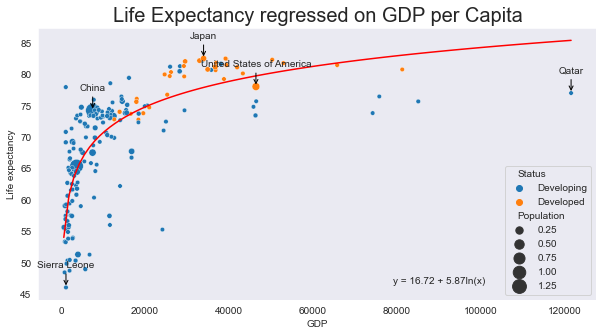

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     282.0
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           9.20e-39
Time:                        14:58:30   Log-Likelihood:                -579.07
No. Observations:                 183   AIC:                             1162.
Df Residuals:                     181   BIC:                             1169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7217      3.155      5.299      0.0

In [ ]:
X_log = sm.add_constant(np.log(grouped_country["GDP"]))
logreg = sm.OLS(grouped_country["Life expectancy "], X_log).fit()

# Calculate the metrics of the model
mse = mean_squared_error(grouped_country["Life expectancy "], logreg.predict(X_log))
r2 = r2_score(grouped_country["Life expectancy "], logreg.predict(X_log))

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Create a range of GDP values to predict on
X_pred = np.linspace(
    grouped_country["GDP"].min(), grouped_country["GDP"].max(), 100
).reshape(-1, 1)

# Transform the GDP values into logarithmic values
X_pred_log = sm.add_constant(np.log(X_pred))

# Make predictions using the weighted logarithmic regression model
y_pred = logreg.predict(X_pred_log)

# countries I want to annotate
annotated_countries = [
    "China",
    "United States of America",
    "Qatar",
    "Sierra Leone",
    "Japan",
]

# create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# create a scatterplot and regression line
sns.scatterplot(
    data=grouped_country,
    x="GDP",
    y="Life expectancy ",
    hue="Status",
    size="Population",
    sizes=(20, 200),
)
# add the regression line
plt.plot(X_pred, y_pred, color="red")

# add the annotation
for country in annotated_countries:
    x = grouped_country.loc[grouped_country["Country"] == country, "GDP"].values[0]
    y = grouped_country.loc[
        grouped_country["Country"] == country, "Life expectancy "
    ].values[0]
    plt.annotate(
        country,
        (x, y),
        textcoords="offset points",
        xytext=(0, 20),
        ha="center",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="black"),
    )

# adding the regression equation
params = logreg.params
eqn = "y = {:.2f} + {:.2f}ln(x)".format(params[0], params[1])
ax.text(0.8, 0.05, eqn, transform=ax.transAxes, ha="right", va="bottom")

# adding the labels and so on.
plt.xlabel("GDP")
plt.ylabel("Life expectancy")
plt.title("Life Expectancy regressed on GDP per Capita", fontsize=20)
plt.show()

# lets see the summary
print(logreg.summary())

### Countries with a low GDP per Capita, but a high life expectancy

In [26]:
filtered_df = grouped_country[
    (grouped_country["Life expectancy "] > 74) & (grouped_country["GDP"] < 13000)
]
filtered_df

,Country,GDP,Population,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,...,Diphtheria,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,rank_HIV,Quantile_HIV,rank_GDP,Quantile_GDP,Status
1,Albania,7740.7500,2968697,75.15625,45.0625,0.6875,4.848750,193.259091,53.3750,49.06875,...,98.0625,1.61875,1.70000,0.709875,12.13750,54.0,0,85.0,1,Developing
20,Bosnia and Herzegovina,7736.9375,3926391,75.96875,64.9375,0.0000,4.130625,215.457459,319.1875,48.96250,...,78.5000,2.78125,2.75625,0.450375,12.22500,10.0,0,84.0,1,Developing
34,China,7474.1875,1321237500,74.26250,73.7500,294.8750,3.921250,73.583763,65857.9375,21.80625,...,93.3125,4.63750,4.02500,0.660250,11.43750,13.0,0,81.0,1,Developing
38,Costa Rica,11673.5625,4460338,78.59375,69.3750,1.0000,3.680000,972.359150,0.1875,46.72500,...,79.7500,1.96250,1.90625,0.736938,12.83750,110.0,1,111.0,2,Developing
40,Cuba,1051.0000,11254238,77.97500,57.5625,1.0000,3.929375,364.563858,0.0000,49.46250,...,93.9375,3.44375,3.26875,0.742125,14.69375,104.0,1,9.0,0,Developing
49,Ecuador,8561.3750,14389810,74.72500,132.1250,7.3750,3.570000,109.406051,20.7500,43.31250,...,89.1875,1.38125,1.26875,0.698875,13.01250,115.0,1,93.0,2,Developing
81,Jamaica,7955.6875,2705276,74.29375,141.2500,1.0000,3.398125,134.249450,0.1875,45.42500,...,89.3125,1.88125,1.73750,0.709625,12.27500,148.0,1,87.0,1,Developing
91,Lebanon,12083.8750,4988668,74.20000,65.3125,1.0000,1.674375,333.047945,295.1875,55.33750,...,70.5000,4.76875,4.71875,0.469687,13.74375,56.0,0,115.0,2,Developing
100,Maldives,12208.6250,341908,75.53750,83.1875,0.0000,1.320000,626.499821,157.8750,19.29375,...,97.8750,14.19375,14.28750,0.638625,12.00000,25.0,0,116.0,2,Developing
108,Montenegro,11354.1875,615843,74.50000,92.7500,0.0000,2.262500,455.049824,0.6250,50.48750,...,89.9375,2.13750,2.18750,0.583750,10.71875,55.0,0,107.0,2,Developing


### Visualization of the Association of BMI and Life expectancy

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     103.1
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           1.48e-30
Time:                        14:58:30   Log-Likelihood:                -595.18
No. Observations:                 183   AIC:                             1196.
Df Residuals:                     180   BIC:                             1206.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          50.6919      2.618     19.364      

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


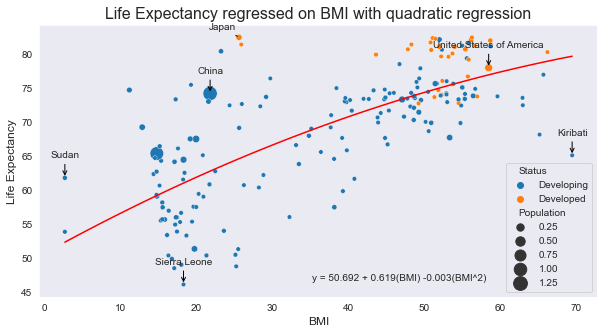

In [27]:
grouped_country["BMI_squared"] = grouped_country[" BMI "] ** 2

# Create a linear regression model with linear and squared terms of BMI
X = sm.add_constant(grouped_country[[" BMI ", "BMI_squared"]])
linreg = sm.OLS(grouped_country["Life expectancy "], X).fit()

# Make predictions on all data
X_pred = np.linspace(
    grouped_country[" BMI "].min(), grouped_country[" BMI "].max(), 100
).reshape(-1, 1)

# Create a new column with squared values of X_pred
X_pred_squared = X_pred**2

# Make predictions using the linear regression model
y_pred = linreg.predict(
    sm.add_constant(
        pd.DataFrame(
            {" BMI ": X_pred.reshape(-1), "BMI_squared": X_pred_squared.reshape(-1)}
        )
    )
)

annotated_countries = [
    "China",
    "Sudan",
    "Kiribati",
    "United States of America",
    "Japan",
    "Sierra Leone",
]
# creating the figure and the axes
fig, ax = plt.subplots(figsize=(10, 5))

# create a scatterplot with regression line
sns.scatterplot(
    data=grouped_country,
    x=" BMI ",
    y="Life expectancy ",
    hue="Status",
    size="Population",
    sizes=(20, 200),
)
plt.plot(X_pred, y_pred, color="red")
plt.title("Life Expectancy regressed on BMI with quadratic regression", fontsize=16)
plt.xlabel("BMI", fontsize=12)
plt.ylabel("Life Expectancy", fontsize=12)


for country in annotated_countries:
    x = grouped_country.loc[grouped_country["Country"] == country, " BMI "].values[0]
    y = grouped_country.loc[
        grouped_country["Country"] == country, "Life expectancy "
    ].values[0]
    if country in ["Japan"]:
        plt.annotate(
            country,
            (x, y),
            textcoords="offset points",
            xytext=(-30, 10),
            va="center",
            arrowprops=dict(
                arrowstyle="-", connectionstyle="arc3", color="black", mutation_scale=20
            ),
        )
    else:
        plt.annotate(
            country,
            (x, y),
            textcoords="offset points",
            xytext=(0, 20),
            ha="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="black"),
        )


params = linreg.params
eqn = "y = {:.3f} + {:.3f}(BMI) {:.3f}(BMI^2)".format(params[0], params[1], params[2])
ax.text(0.8, 0.05, eqn, transform=ax.transAxes, ha="right", va="bottom")

print(linreg.summary())

### Countries with a low BMI , but a high life expectancy

In [28]:
filtered_df = grouped_country[
    (grouped_country["Life expectancy "] > 70) & (grouped_country[" BMI "] < 30)
]
filtered_df["Country"]

23     Brunei Darussalam
27            Cabo Verde
34                 China
82                 Japan
99              Malaysia
100             Maldives
104            Mauritius
130    Republic of Korea
142           Seychelles
144            Singapore
152            Sri Lanka
160             Thailand
179             Viet Nam
Name: Country, dtype: object

## Time series graphs

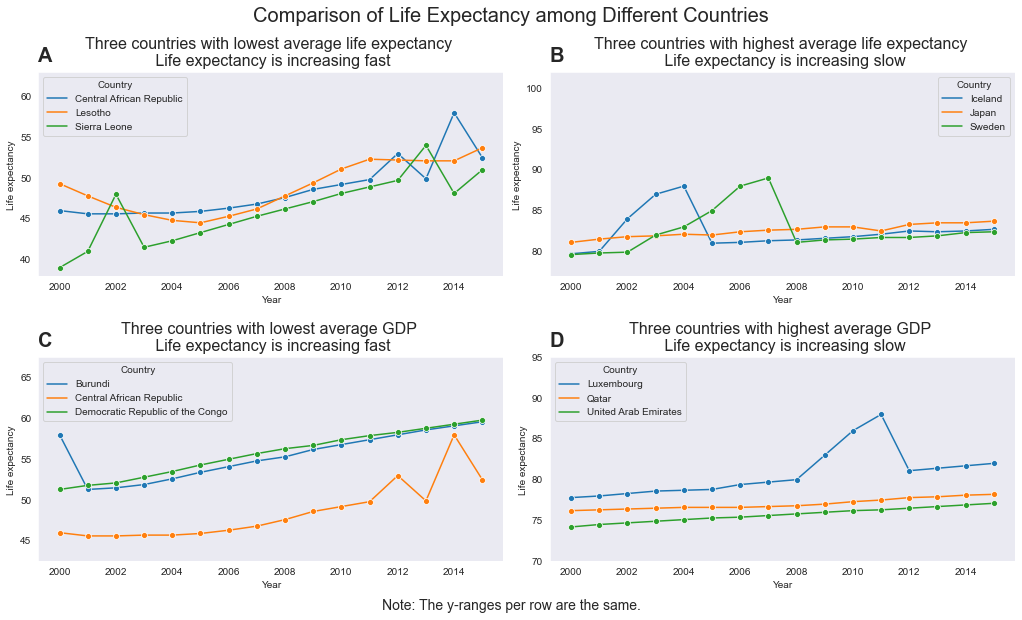

In [29]:
# Choosing the countries with the n smallest/largest life expectancy
n = 3
n_smallest_life_expectancy = df[
    df["Country"].isin(
        grouped_country.nsmallest(n, "Life expectancy ")["Country"].to_list()
    )
]
n_largest_life_expectancy = df[
    df["Country"].isin(
        grouped_country.nlargest(n, "Life expectancy ")["Country"].to_list()
    )
]

# creating the fig and subplots
# all plots have the same range, to make the data visually comparable.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(17.5, 9))

# Plot for the first quarter of the data
sns.lineplot(
    data=n_smallest_life_expectancy,
    x="Year",
    y="Life expectancy ",
    hue="Country",
    marker="o",
    ax=ax1,
)
ax1.set_title(
    "Three countries with lowest average life expectancy \n Life expectancy is increasing fast",
    fontsize=16,
)
# set the y-axis limits
ax1.set_ylim(38, 38 + 25)

# Plot for the second quarter of the data
# all plots have the same range, to make the data visually comparable.
sns.lineplot(
    data=n_largest_life_expectancy,
    x="Year",
    y="Life expectancy ",
    hue="Country",
    marker="o",
    ax=ax2,
)
ax2.set_title(
    "Three countries with highest average life expectancy \n Life expectancy is increasing slow",
    fontsize=16,
)
ax2.set_ylim(77, 77 + 25)


# Choosing the countries with the n smallest/largest GDP
n = 3
n_smallest_GDP = df[
    df["Country"].isin(grouped_country.nsmallest(n, "GDP")["Country"].to_list())
]
n_largest_GDP = df[
    df["Country"].isin(grouped_country.nlargest(n, "GDP")["Country"].to_list())
]


# Plot for the third quarter of the data
# all plots have the same range, to make the data visually comparable.
sns.lineplot(
    data=n_smallest_GDP,
    x="Year",
    y="Life expectancy ",
    hue="Country",
    marker="o",
    ax=ax3,
)

ax3.set_title(
    "Three countries with lowest average GDP \n Life expectancy is increasing fast",
    fontsize=16,
)
ax3.set_ylim(42.5, 42.5 + 25)  # set the y-axis limits

# Plot for the fourth quarter of the data
# all plots have the same range, to make the data visually comparable.
sns.lineplot(
    data=n_largest_GDP,
    x="Year",
    y="Life expectancy ",
    hue="Country",
    marker="o",
    ax=ax4,
)
ax4.set_title(
    "Three countries with highest average GDP \n Life expectancy is increasing slow",
    fontsize=16,
)
ax4.set_ylim(70, 70 + 25)

ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=20, weight="bold")
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=20, weight="bold")
ax3.text(0, 1.05, "C", transform=ax3.transAxes, size=20, weight="bold")
ax4.text(0, 1.05, "D", transform=ax4.transAxes, size=20, weight="bold")

# adjust the spacing
plt.subplots_adjust(wspace=0.1, hspace=0.4)
fig.text(
    0.5, 0.05, "Note: The y-ranges per row are the same.", ha="center", fontsize=14
)

# add a title
fig.suptitle("Comparison of Life Expectancy among Different Countries", fontsize=20)
plt.show()

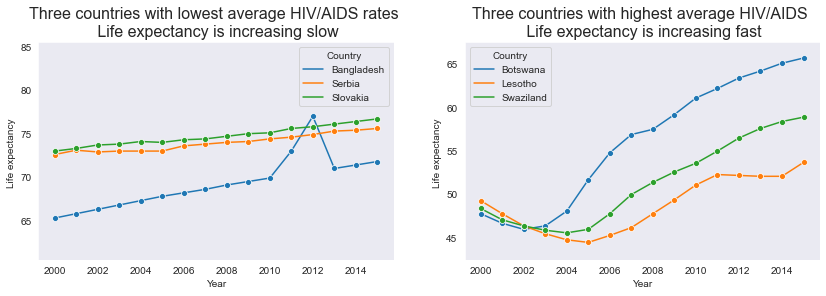

In [30]:
n = 3
n_smallest_HIV = df_imputed[
    df_imputed["Country"].isin(
        grouped_country.nsmallest(n, " HIV/AIDS")["Country"].to_list()
    )
]
n_largest_HIV = df_imputed[
    df_imputed["Country"].isin(
        grouped_country.nlargest(n, " HIV/AIDS")["Country"].to_list()
    )
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot for the first half of the data
sns.lineplot(
    data=n_smallest_HIV,
    x="Year",
    y="Life expectancy ",
    hue="Country",
    marker="o",
    ax=ax1,
)
ax1.set_title(
    "Three countries with lowest average HIV/AIDS rates \n Life expectancy is increasing slow",
    fontsize=16,
)
ax1.set_ylim(60.5, 60.5 + 25)

# Plot for the second half of the data
# both plots have the same range, to make the data visually comparable.
sns.lineplot(
    data=n_largest_HIV,
    x="Year",
    y="Life expectancy ",
    hue="Country",
    marker="o",
    ax=ax2,
)
ax2.set_title(
    "Three countries with highest average HIV/AIDS \n Life expectancy is increasing fast",
    fontsize=16,
)
ax2.set_ylim(55.5, 55.5 + 25)  # set the y-axis limits
ax2.set_ylim(42.5, 42.5 + 25)

plt.show()

### Analyzing the development life expectancy in states with low and high HIV rates over time

In [31]:
# creating a function to calculate the weighted average
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()


# creating a df without string values
df_imputed_drop_status = df_imputed.drop(columns="Status")

# creating the weighted average df
df_list = []
for col in df_imputed_drop_status.columns[2:]:
    if col == "Population":
        df_list.append(df_imputed_drop_status.groupby("Year").sum()[["Population"]])
    else:
        df_list.append(
            df_imputed_drop_status.groupby("Year").apply(w_avg, col, "Population")
        )

# adding the column names
df_imputed_weighted = pd.concat(df_list, axis=1).reset_index()
df_imputed_weighted.columns = df_imputed_drop_status.columns[1:]

# droppping the unused df for memory reasons
del df_imputed_drop_status

### Analyzing quality of life indicators world wide for the time period between 2000 - 2015

In [32]:
df_imputed_weighted["combined vaccination rates"] = (
    df_imputed_weighted["Diphtheria "] + df_imputed_weighted["Polio"]
) / 2

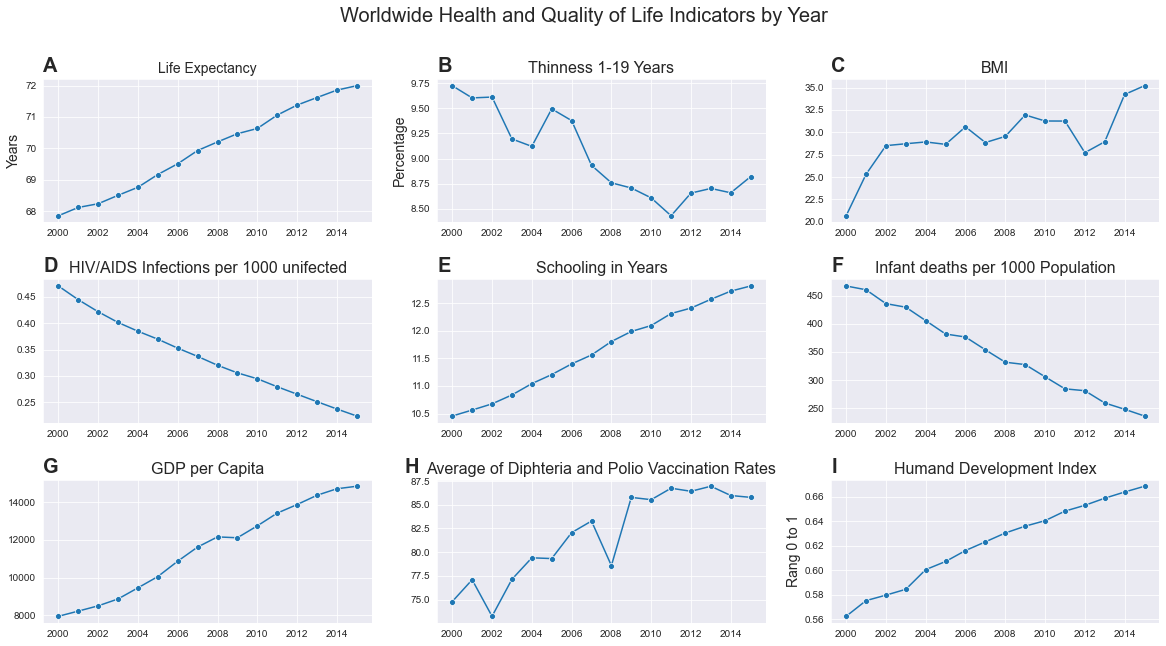

In [33]:
sns.set_style("dark")

# creating a figure and the subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(
    3, 3, figsize=(20, 10)
)

# Plot for the first element
sns.lineplot(
    data=df_imputed_weighted, x="Year", y="Life expectancy ", marker="o", ax=ax1
)
ax1.set_title("Life Expectancy", fontsize=14)
ax1.set_ylabel("Years", fontsize=14)
ax1.set_xlabel("")
ax1.grid(True)

# Plot for the second element
sns.lineplot(
    data=df_imputed_weighted, x="Year", y=" thinness  1-19 years", marker="o", ax=ax2
)
ax2.set_title("Thinness 1-19 Years", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=14)
ax2.set_xlabel("")
ax2.grid(True)

# Plot for the third element
sns.lineplot(data=df_imputed_weighted, x="Year", y=" BMI ", marker="o", ax=ax3)
ax3.set_title("BMI", fontsize=16)
ax3.set_ylabel("", fontsize=14)
ax3.set_xlabel("")
ax3.grid(True)

# Plot for the fourth element
sns.lineplot(data=df_imputed_weighted, x="Year", y=" HIV/AIDS", marker="o", ax=ax4)
ax4.set_title("HIV/AIDS Infections per 1000 unifected", fontsize=16)
ax4.set_ylabel("", fontsize=14)
ax4.set_xlabel("")
ax4.grid(True)

# Plot for the fifth element
sns.lineplot(data=df_imputed_weighted, x="Year", y="Schooling", marker="o", ax=ax5)
ax5.set_title("Schooling in Years", fontsize=16)
ax5.set_ylabel("", fontsize=14)
ax5.set_xlabel("")
ax5.grid(True)

# Plot for the sixth element
sns.lineplot(data=df_imputed_weighted, x="Year", y="infant deaths", marker="o", ax=ax6)
ax6.set_title("Infant deaths per 1000 Population", fontsize=16)
ax6.set_ylabel("", fontsize=14)
ax6.set_xlabel("")
ax6.grid(True)

# Plot for the seventh element
sns.lineplot(data=df_imputed_weighted, x="Year", y="GDP", marker="o", ax=ax7)
ax7.set_title("GDP per Capita", fontsize=16)
ax7.set_ylabel("", fontsize=14)
ax7.set_xlabel("")
ax7.grid(True)

# Plot for the eight element
sns.lineplot(
    data=df_imputed_weighted,
    x="Year",
    y="combined vaccination rates",
    marker="o",
    ax=ax8,
)
ax8.set_title("Average of Diphteria and Polio Vaccination Rates", fontsize=16)
ax8.set_ylabel("", fontsize=14)
ax8.set_xlabel("")
ax8.grid(True)

# Plot for the nineth element
sns.lineplot(
    data=df_imputed_weighted,
    x="Year",
    y="Income composition of resources",
    marker="o",
    ax=ax9,
)
ax9.set_title("Humand Development Index", fontsize=16)
ax9.set_ylabel("Rang 0 to 1", fontsize=14)
ax9.set_xlabel("")
ax9.grid(True)

# adding annotations
ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=20, weight="bold")
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=20, weight="bold")
ax3.text(0, 1.05, "C", transform=ax3.transAxes, size=20, weight="bold")
ax4.text(0, 1.05, "D", transform=ax4.transAxes, size=20, weight="bold")
ax5.text(0, 1.05, "E", transform=ax5.transAxes, size=20, weight="bold")
ax6.text(0, 1.05, "F", transform=ax6.transAxes, size=20, weight="bold")
ax7.text(0, 1.05, "G", transform=ax7.transAxes, size=20, weight="bold")
ax8.text(-0.1, 1.05, "H", transform=ax8.transAxes, size=20, weight="bold")
ax9.text(0, 1.05, "I", transform=ax9.transAxes, size=20, weight="bold")


# adjust the spacing and adding suptitle
plt.subplots_adjust(wspace=0.2, hspace=0.4)
fig.suptitle("Worldwide Health and Quality of Life Indicators by Year", fontsize=20)


plt.show()

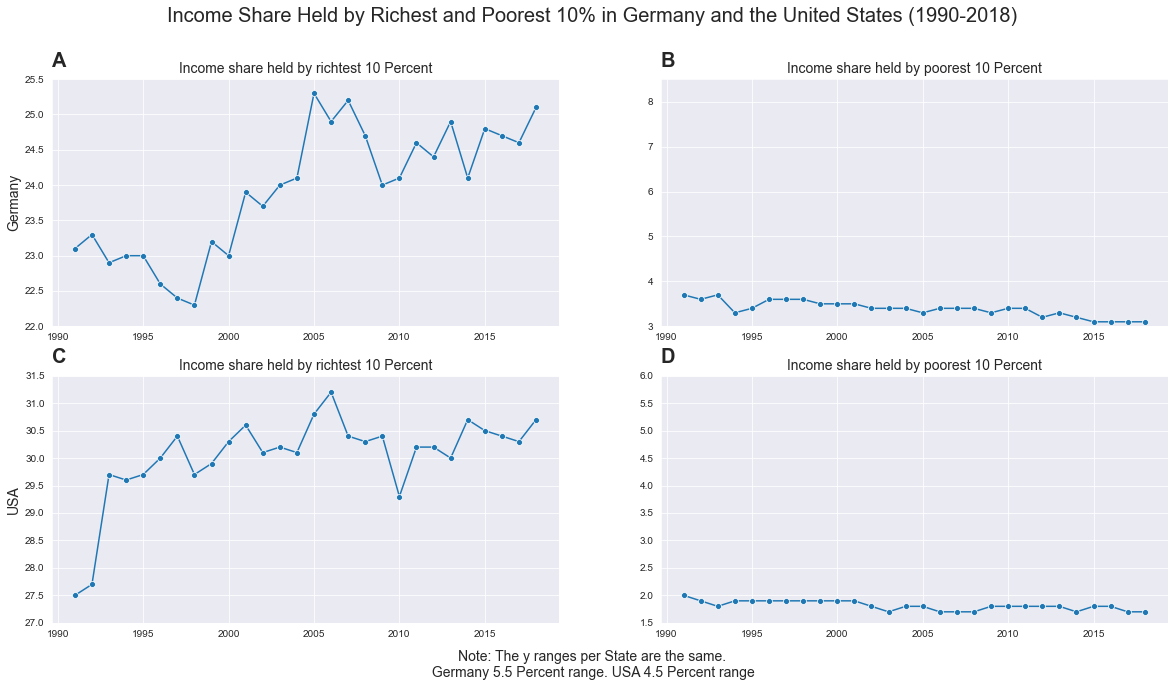

In [34]:
# preparing the data to visualisze them
richtest_10_germany = df_melted_income[
    (df_melted_income["Series Name"] == "Income share held by highest 10%")
    & (df_melted_income["Country"] == "Germany")
]
poorest_10_germany = df_melted_income[
    (df_melted_income["Series Name"] == "Income share held by lowest 10%")
    & (df_melted_income["Country"] == "Germany")
]
richtest_10_USA = df_melted_income[
    (df_melted_income["Series Name"] == "Income share held by highest 10%")
    & (df_melted_income["Country"] == "United States")
]
poorest_10_USA = df_melted_income[
    (df_melted_income["Series Name"] == "Income share held by lowest 10%")
    & (df_melted_income["Country"] == "United States")
]

# preparing a df for the relationship of income rations in Germany
income_ratios = []

for year in richtest_10_germany["Year"]:
    ratio = (
        richtest_10_germany.loc[richtest_10_germany["Year"] == year].values[0][3]
        / poorest_10_germany.loc[poorest_10_germany["Year"] == year].values[0][3]
    )
    income_ratios.append({"Year": year, "Income Ratio": ratio})

df_income_ratios_Germany = pd.DataFrame(income_ratios)

# preparing a df for the relationship of income rations in the USA
income_ratios = []

for year in richtest_10_USA["Year"]:
    ratio = (
        richtest_10_USA.loc[richtest_10_USA["Year"] == year].values[0][3]
        / poorest_10_USA.loc[poorest_10_USA["Year"] == year].values[0][3]
    )
    income_ratios.append({"Year": year, "Income Ratio": ratio})

df_income_ratios_USA = pd.DataFrame(income_ratios)

# creating a figure and subplots

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

# Plot for the first half of the data
# again the same y limits to make it comparable
sns.lineplot(
    data=df_melted_income[
        (df_melted_income["Series Name"] == "Income share held by highest 10%")
        & (df_melted_income["Country"] == "Germany")
    ],
    x="Year",
    y="Income Share",
    marker="o",
    ax=ax1,
)
ax1.set_title("Income share held by richtest 10 Percent", fontsize=14)
ax1.set_ylabel("Germany", fontsize=14)
ax1.set_xlabel("")
ax1.grid(True)
ax1.set_ylim(22, 20 + 5.5)


sns.lineplot(
    data=df_melted_income[
        (df_melted_income["Series Name"] == "Income share held by lowest 10%")
        & (df_melted_income["Country"] == "Germany")
    ],
    x="Year",
    y="Income Share",
    marker="o",
    ax=ax2,
)
ax2.set_title("Income share held by poorest 10 Percent", fontsize=14)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.grid(True)
ax2.set_ylim(3, 3 + 5.5)

# Plot for the second half of the data
# again the same y limits to make it comparable
sns.lineplot(
    data=df_melted_income[
        (df_melted_income["Series Name"] == "Income share held by highest 10%")
        & (df_melted_income["Country"] == "United States")
    ],
    x="Year",
    y="Income Share",
    marker="o",
    ax=ax3,
)
ax3.set_title("Income share held by richtest 10 Percent", fontsize=14)
ax3.set_ylabel("USA", fontsize=14)
ax3.set_xlabel("")
ax3.grid(True)
ax3.set_ylim(27, 27 + 4.5)


sns.lineplot(
    data=df_melted_income[
        (df_melted_income["Series Name"] == "Income share held by lowest 10%")
        & (df_melted_income["Country"] == "United States")
    ],
    x="Year",
    y="Income Share",
    marker="o",
    ax=ax4,
)
ax4.set_title("Income share held by poorest 10 Percent", fontsize=14)
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.grid(True)
ax4.set_ylim(1.5, 1.5 + 4.5)

# adding annotations for more readability
ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=20, weight="bold")
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=20, weight="bold")
ax3.text(0, 1.05, "C", transform=ax3.transAxes, size=20, weight="bold")
ax4.text(0, 1.05, "D", transform=ax4.transAxes, size=20, weight="bold")

# adding a nice suptitle
fig.suptitle(
    "Income Share Held by Richest and Poorest 10% in Germany and the United States (1990-2018)",
    fontsize=20,
)
# adding a note
fig.text(
    0.5,
    0.05,
    "Note: The y ranges per State are the same.\n Germany 5.5 Percent range. USA 4.5 Percent range",
    ha="center",
    fontsize=14,
)


plt.show()

### Multiples of income or the top ten percent vs the lowest ten percent of income

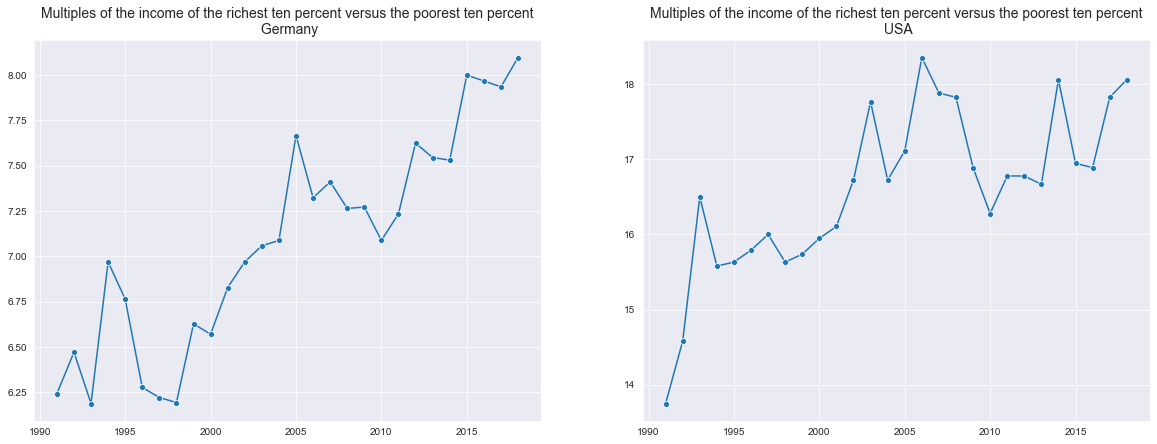

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.lineplot(
    data=df_income_ratios_Germany, x="Year", y="Income Ratio", marker="o", ax=ax1
)
ax1.set_title(
    "Multiples of the income of the richest ten percent versus the poorest ten percent\n Germany",
    fontsize=14,
)
ax1.set_ylabel("", fontsize=14)
ax1.set_xlabel("")
ax1.grid(True)

sns.lineplot(data=df_income_ratios_USA, x="Year", y="Income Ratio", marker="o", ax=ax2)
ax2.set_title(
    "Multiples of the income of the richest ten percent versus the poorest ten percent\n USA",
    fontsize=14,
)
ax2.set_ylabel("", fontsize=14)
ax2.set_xlabel("")
ax2.grid(True)

plt.show()